# iSIM - sigma

## Notebook contents:
- Generation of random fingerprints
- Testing of RR standard deviation approximation on random fingerprints
- Testing of RR standard deviation on fingerprints from real molecules
- Testing of the exact RR standard deviation calculation

Miranda-Quintana Group
University of Florida

Kenneth Lopez Perez

### Generation of random fingerprints

In [2]:
import numpy as np

# Generation of 1000 random binary fingerprints
np.random.seed(72)
random_fp =  np.random.randint(0, 2, (1000, 2048))

### Testing of the RR standard deviation approximation

With the iSIM module it was possible to calculate the average pairwise similarity without doing all the possible pairs, only the columnwise sum was required. If we follow a similar approach we could get the approximation of the standard deviation of the similarities just with the columnwise sum. 

Russell-Rao is defined by:

$$
RR = \frac{a}{p}
$$

where a corresponds to the number of one-one matches between fingerprints and p to the total of comparisons. 

With the columnwise vector, we can get the number of one-one coincidences for each column. Let the columwise sum vector be:

$$
column \ sum = [k_1, k_2, ..., k_m]
$$

for fingerprints of length m. 

Then the number of one-one coincidences per column will be equal to:

$$
a_i = \frac{k_i(k_i-1)}{2}
$$

And we can get a vector for the a values per column as shown below, and to gather the information of the whole vector we sum them.

$$
a = \Sigma a_i = \sum{\frac{k_i(k_i-1)}{2}}
$$

In [3]:
# Columnwise sum of the random fingerprints
column_sum = np.sum(random_fp, axis=0)

# Calculation of the number of pairs of 1s in each column
a_per_column = column_sum * (column_sum - 1) / 2
print(a_per_column)

# Calculation of the total number of pairs of 1s in the whole matrix
a = np.sum(a_per_column)
print('a:', a)

[123256. 132870. 127765. ... 121771. 115921. 131328.]
a: 255357076.0


Now to get the total number of comparissons we calculate:
$$
p = \frac{n(n-1)m}{2}
$$

In [4]:
n, m = random_fp.shape

# Calculation of the total number of comparisons with the iSIM method
p = n * (n - 1) * m / 2
print('p:', p)

p: 1022976000.0


Now to obtain the average RR pairwise value, we simply do a/p.

In [5]:
RR = a / p
print('RR:', RR)

RR: 0.24962176629754754


This function is implemented in the iSIM module, and we can compare it to the average pariwise value. 

In [ ]:
from isim_sigma.isim import calculate_isim
from isim_sigma.utils import pairwise_average
import time

# Calculation of the iSIM value
start1 = time.time()
isim_RR = calculate_isim(random_fp, n_ary='RR')
end1 = time.time()

print('isim_RR:', isim_RR)
print('Time:', end1 - start1, 's')
print("--------------------")


# Calculation of the average pairwise similarity
start2 = time.time()
average_pairwise, standard_deviation = pairwise_average(random_fp, n_ary='RR')
end2 = time.time()

print('Average pairwise RR:', average_pairwise)
print('Time:', end2 - start2, 's')
print("--------------------")

# Calculation of the difference between the iSIM value and the average pairwise similarity and the timing ratio
print('Difference:', isim_RR - average_pairwise)
print('Timing ratio:', (end2 - start2) / (end1 - start1))


isim_RR: 0.24962176629754754
Time: 0.0022423267364501953 s
--------------------
Average pairwise RR: 0.24962176629754754
Time: 1.9558014869689941 s
--------------------
Difference: 0.0
Timing ratio: 872.2196703880915


As it can be apreaciated, doing the pairwise average takes way longer than the iSIM method, but the values are exactly the same.

As the reader may have noticed, the average RR index is basically the proportion of total one-one coincidences in all the posible columnwise bit comparisons that can be done. When comparing only bits, the RR index has only two possible values: RR = 1 for a one-one match, or RR for a nonmatches or zero-zero matches. Hence, when calculating the average pairwise RR with the iSIM metric, what we are basically doing is getting the average of a binomial distribution. 

It would be intuitive then to calculate the variance of the average pairwise comparisons as the variance of a binomial distribution. 

The normal approximation of a binomial distribution is given by:

$$
\sigma = \sqrt{\frac{p(1-p)}{n}}
$$

where p is the proportion of 1s in the distribution and n the total number of samples. Translating the formula to our framework, the standard deviation could be calculated with the following:

$$
\sigma = \sqrt{\frac{RR(1-RR)}{m}}
$$

In our case, RR is the proportion of 1s in all the bit comparisons anb since we are using a columnwise approach, our number of samples would be the number of columns, m.

In [7]:
isim_sigma = np.sqrt(RR * (1 - RR)/m)
print('isim_sigma:', isim_sigma)

print('Standard deviation:', standard_deviation) ### Calculated above when compared to the pairwise average


isim_sigma: 0.00956348902381413
Standard deviation: 0.009235858966327233


As it can be seen, the number is not exact, we are using the normal approximation, hance the fingerprints do not have exactly a normal binomial distribution. Below we compare the approximation for multiple sets of different number of fingerprints and lengths. 

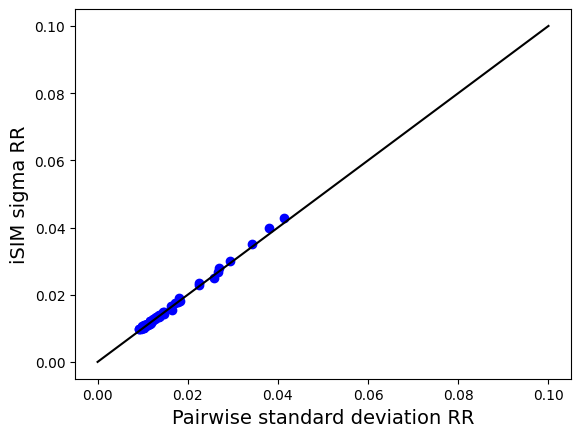

In [8]:
from matplotlib import pyplot as plt

# Plot of the average pairwise similarity and the iSIM value for standard deviation calculation
fig = plt.figure()
for i in range(50):
    fps = np.random.randint(0, 2, (np.random.randint(100, 500), np.random.randint(100, 2048)))
    isim_RR = calculate_isim(fps, n_ary='RR')
    isim_std = np.sqrt(isim_RR * (1 - isim_RR)/fps.shape[1])
    average_pairwise, standard_deviation = pairwise_average(fps, n_ary='RR')

    plt.scatter(standard_deviation, isim_std, color='blue')

plt.plot([0, 0.1], [0, 0.1], color='black')
plt.ylabel('iSIM sigma RR', fontsize=14)
plt.xlabel('Pairwise standard deviation RR', fontsize=14)

plt.savefig('figures/RR_normal_binomial_random.png', dpi = 400)

With this exercise, we can see that the approximation despite of not being excat, is quite good. However, the fingerprints for real molecules are far from having a normal binomial distribution. Then we expect our trick not to work as well.

### Testing of RR on fingerprints from real molecules

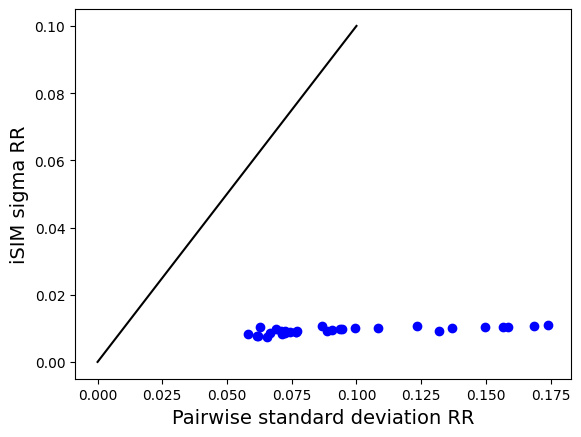

In [9]:
import glob

fig = plt.figure()
for file in glob.glob("rdkit/*.npy"):
    # Load fingerprint files
    fps = np.load(file, mmap_mode='r')

    # Calculate the iSIM sigma RR standard deviation
    isim_RR = calculate_isim(fps, n_ary='RR')
    isim_std = np.sqrt(isim_RR * (1 - isim_RR)/fps.shape[1])

    # Calculate the pairwise standard deviation of RR
    pairwise_std = pairwise_average(fps, n_ary="RR")[1]

    # Plot the point
    plt.scatter(pairwise_std, isim_std, color = 'blue')

plt.plot([0,0.1],[0, 0.1], color = 'black')
plt.ylabel('iSIM sigma RR', fontsize=14)
plt.xlabel('Pairwise standard deviation RR', fontsize=14)

plt.savefig('figures/RR_normal_binomial_chembl.png', dpi = 400)


From this section we confirmed that the distribution of bits in real-molecule fingerprints is far from normality. Hence the distribution of them across the fingerprints must be taken into consideration. 

### Testing of the exact RR standard deviation calculation

For a given pair of fingerprints, $a$ is defined according to the following formula.

$$
a = \sum_{i=1}^{M} p_i
$$

Where $p_i$ is 1 if both molecules have a value of 1 at position $i$, and 0 otherwise. For iSIM, to compute the average value of $a$, $E(a)$, we used linearity of expectation according to equation 7, where $E(p_i)$ is simply $\frac{k_i(k_i-1)}{n(n-1)}$.

$$
E(a) = \sum_{i=1}^{M} E(p_i)
$$

The variance of $a$ doesn't follow this same linearity, but instead expands to include covariances between terms, where $\sigma_{p_i, p_j}$ is the covariance between $p_i$ and $p_j$.

$$
\sigma^2_a = \sum_{i=1}^{M}{\sigma^2_{p_i}} + 2\sum_{i=1}^{M}\sum_{j=i+1}^{M}{\sigma_{p_i, p_j}}
$$

Since $p_i$ can only have a value of 0 or 1, it follows a Bernoulli distribution, and has a variance following equation.

$$
\sigma^2_{p_i} = E(p_i)(1-E(p_i))
$$

We additionally note that covariance is defined according to:

$$
\sigma_{p_i, p_j} = E(p_ip_j) - E(p_i)E(p_j)
$$

From the previous equations we can therefore compute $\sigma^2_a$ if we know $E(p_i  p_j)$ for any pair of $i$ and $j$, and $E(p_i)$ for any $i$. $E(p_i)$, as previously mentioned, is computed from iSIM and takes $O(N)$ time. $E(p_i  p_j)$ is simply the probability that when selecting a pair of two molecules, there is a value of 1 for both molecules at positions $i$ and $j$. Thus, similar to how we computed $E(p_i)$, we go through each of the molecules and enumerate the number of instances where there is a 1 in both positions $i$ and $j$, defined as $\alpha_{ij}$. Since there are $\frac{\alpha_{ij}(\alpha_{ij}-1)}{2}$ pairs where $p_i p_j$ is 1, and $\frac{N(N-1)}{2}$ total pairs, $E(p_i  p_j)$ simply follows equation:

$$
E(p_i p_j) = \frac{\alpha_{ij}(\alpha_{ij}-1)}{N(N-1)}
$$

Determining $\alpha_{ij}$ takes $O(N)$ time, and we must do this for all $O(M^2)$ pairs, thus, determining all the covariances takes $O(NM^2)$ time. We can therefore obtain the variance of $a$ in $O(NM^2)$ time, and all we need to do is square root this, and then divide it by $m$ to get the standard deviation of the RR metric.

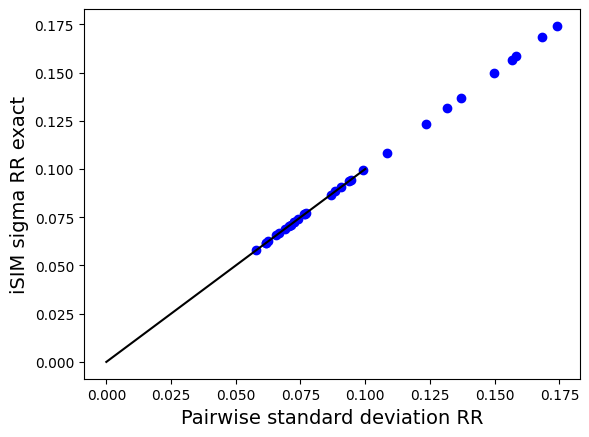

In [ ]:
from isim_sigma.sigma import get_stdev_russell_fast

fig = plt.figure()
for file in glob.glob("rdkit/*.npy"):
    # Load fingerprint files
    fps = np.load(file, mmap_mode='r')

    # Calculate the iSIM sigma RR standard deviation
    RR_exact = get_stdev_russell_fast(fps)

    # Calculate the pairwise standard deviation of RR
    pairwise_std = pairwise_average(fps, n_ary="RR")[1]

    # Plot the point
    plt.scatter(pairwise_std, RR_exact, color = 'blue')

plt.plot([0,0.1],[0, 0.1], color = 'black')
plt.ylabel('iSIM sigma RR exact', fontsize=14)
plt.xlabel('Pairwise standard deviation RR', fontsize=14)

plt.savefig('figures/RR_fast_exact_chembl.png', dpi = 400)
